In [1]:
# Authors: Alpha Diallo & Korey Clement

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
'''
#  Attribute                     Domain
-- -----------------------------------------
1. Sample code number            id number
2. Clump Thickness               1 - 10
3. Uniformity of Cell Size       1 - 10
4. Uniformity of Cell Shape      1 - 10
5. Marginal Adhesion             1 - 10
6. Single Epithelial Cell Size   1 - 10
7. Bare Nuclei                   1 - 10
8. Bland Chromatin               1 - 10
9. Normal Nucleoli               1 - 10
10. Mitoses                       1 - 10
11. Class:                        (2 for benign, 4 for malignant)
'''
f = 'data/breast-cancer-wisconsin'
col_names = ['Sample Code Number', 'Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape',
                              'Marginal Adhesion', 'Single Epithetlial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
                              'Normal Nucleoli', 'Mitosis', 'Class']
df = pd.read_csv(f+'.data', names=col_names, header=None)
df['Class'].unique()
df['Class'] = df['Class'].replace(2,0)
df['Class'] = df['Class'].replace(4,1)

In [3]:
def converttonumber(x):
    try:
        float(x)
        return True
    except:
        return False

df = df[df.applymap(converttonumber)]

df = df.dropna()
data = df.values

In [4]:
X = data[:,1:10].astype('float')
X = np.delete(X, np.s_[1:2], axis=1)
#X = np.log(X)
y = data[:,10].astype('int')


print('Shape of Dataset:', X.shape)
print('Shape of labels', y.shape)

Shape of Dataset: (683, 8)
Shape of labels (683,)


### Distribution Of The Data

In [5]:
import seaborn as sns

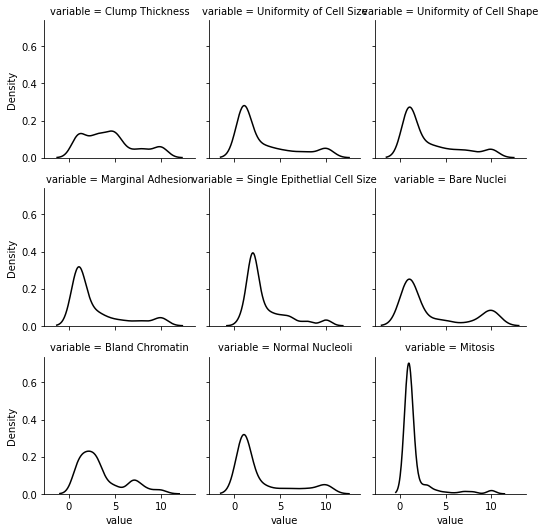

In [6]:
#d = np.sqrt(df[df.columns[1:10]].astype('float')) # Reduce skewness of data points
d = df[df.columns[1:10]].astype('float')
g = sns.FacetGrid(pd.melt(d), col="variable", col_wrap=3, height=2.5)
g.map(sns.kdeplot,'value', color='black')
plt.show()

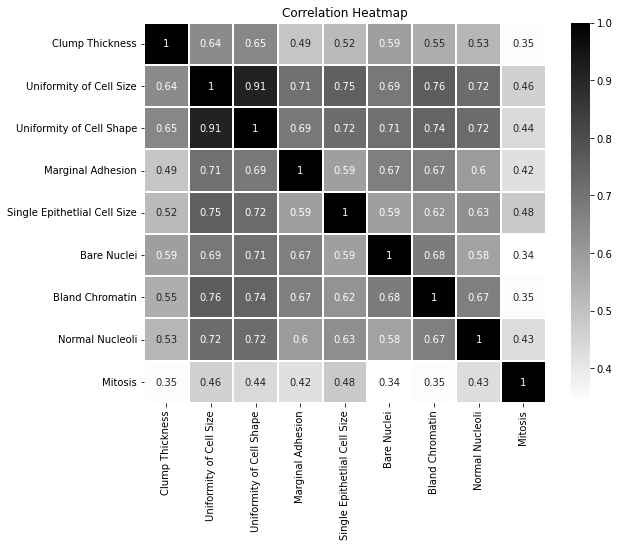

In [7]:
# Correlation Matrix
f, ax = plt.subplots(figsize=(9, 7))
corr = d.corr()
hm = sns.heatmap(round(corr,2), cmap="gray_r", ax=ax, annot=True,
                 linewidths=.03)

hm.set_title('Correlation Heatmap')
plt.show()

### PCA - 2 Dimensional
<br />

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)


In [29]:
print('Explained Variance Ratio:', pca.explained_variance_ratio_)
print('Total Explained Variance:',sum(pca.explained_variance_ratio_))

Explained Variance Ratio: [0.67041356 0.0794606 ]
Total Explained Variance: 0.7498741630801248


Text(0.5, 1.0, 'PCA 2 Components')

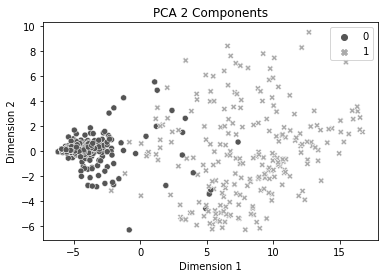

In [11]:
d2 = pd.DataFrame(X, columns = ['Dimension 1','Dimension 2'])

p3 = sns.scatterplot(data=d2, x="Dimension 1", y="Dimension 2", hue=y, style=y, 
                palette='binary_r')

p3.set_title('PCA 2 Components')


In [12]:
# # Find outliers
# # for i in range(0,683):
# #     if X[i][0] > 0.6e7:
# #         print(X[i], i)

# Xc = np.delete(X, (646), axis=0)
# Xc = np.delete(Xc, (514), axis=0)


# yc = np.delete(y, (646), axis=0)
# yc = np.delete(yc, (514), axis=0)


# d3 = pd.DataFrame(Xc, columns = ['Dimension 2','Dimension 1'])

# p4 = sns.scatterplot(data=d3, x="Dimension 1", y="Dimension 2", hue=yc, style=yc, 
#                 palette='binary_r')

# p4.set_title('PCA - Outliers Removed')

# plt.show()



In [13]:
# End of PCA Section!

In [14]:
ones = np.ones(X.shape[0]).reshape(-1,1)
X = np.hstack([ones,X])
print('New dataset dimensions:', X.shape)

New dataset dimensions: (683, 3)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Logistic Regression Section

In [16]:
def linearmodel(theta, x):
    # First row of theta is the bias (intercept) term
    #print(theta.shape, x.shape)
    return theta @ x

def sigmoid(a):
    # compute sigmoid of model
    return np.exp(np.fmin(a, 0)) / (1 + np.exp(-np.abs(a))) 


def cross_entropy(w,x,y):
    model = linearmodel(w.T,x)
    lf = (y*model-np.log(1+np.exp(model)))
    losstotal = -np.sum(lf)/y.shape[0]
    return losstotal


def gradient(x,yhat,y):
    return (x @ (yhat - y))/y.shape[0] 

def logreg(x,y,iterations, learning_rate, tol):
    W = np.zeros(x.shape[0]) # Initialize theta
    loss_ = []
    weights = []
    weights.append(W)
    for i in range(0, iterations):
        model = linearmodel(W.T, x)
        yhat = sigmoid(model)
        gradient_ = gradient(x,yhat,y).reshape(-1)
        
        loss = cross_entropy(W,x,y)
        loss_.append(loss)
        
        if i > 0:
            j = i-1
            if abs(loss_[i]-loss_[j]) < tol:
                print('Converged at ' + str(i) + ' iterations.')
                print('Cost minimized to', np.round(loss,4))
                break
            
        W -= gradient_*learning_rate
        weights.append(W)
        
    return  W, loss_, weights

In [17]:
Wt, loss, weights = logreg(X_train.T, y_train, 1000, 0.01, 0.0001)

Converged at 175 iterations.
Cost minimized to 0.1102


In [18]:
model=np.dot(X_test,Wt)
yhat=np.round(sigmoid(model))


from sklearn.metrics import accuracy_score
accuracy = accuracy_score(yhat, y_test)
print("Accuracy Score:", np.round(accuracy*100,3))

Accuracy Score: 98.673


[Text(0, 0.5, 'Benign'), Text(0, 1.5, 'Malignant')]

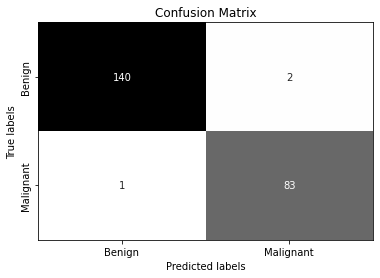

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, yhat)

ax= plt.subplot()
res = sns.heatmap(cm, annot=True, fmt='g', cbar=False, cmap='binary', ax=ax) 

for _, spine in res.spines.items():
    spine.set_visible(True)
    
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant'])

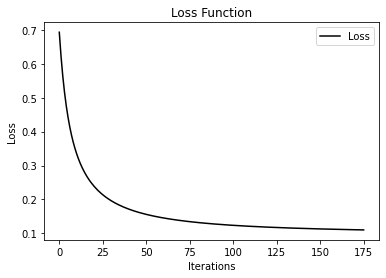

In [20]:
iter_ = [*range(len(loss))]
p5 = sns.lineplot(x=iter_, y=loss, color='black')
p5.set_title('Loss Function')
p5.set_xlabel("Iterations")
p5.set_ylabel("Loss")
plt.legend(labels=["Loss"])
plt.show()

In [21]:
### Plot decision boundary
x_min = X_test[:,1:2].min()
x_max = X_test[:,1:2].max()
y_min = X_test[:,2:3].min()
y_max = X_test[:,2:3].max()
x_grid, y_grid = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min, y_max, .05))

xx = x_grid.ravel()
yy = y_grid.ravel()
intercept = np.ones((xx.shape))

z = np.vstack([intercept, xx])
z = np.vstack([z, yy])
z = z.T

zmodel = np.dot(z,Wt)
zpredict = np.round(sigmoid(zmodel)).reshape(-1,1)
zpredict = zpredict.reshape(x_grid.shape)

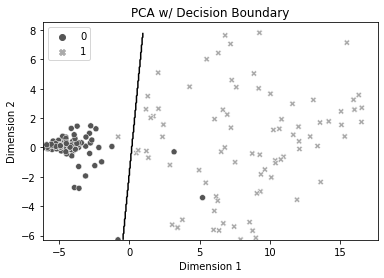

In [22]:
d3 = pd.DataFrame(X_test, columns = ['Intercept', 'Dimension 1','Dimension 2'])

p4 = sns.scatterplot(data=d3, x="Dimension 1", y="Dimension 2", hue=y_test, style=y_test, 
                palette='binary_r')

p4.set_title('PCA w/ Decision Boundary')

plt.contour(x_grid, y_grid, zpredict, levels = [0.1], cmap='gray') # Decision boundary



In [23]:
# That's all, folks!